Tara Movaghar, Daniel Yglesias, Joshua Onsongo, Emily Khuu, Fiyinfoluwa Seinde-Olaniyi 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#basic panda for data
df=pd.read_csv("house_price.csv")
df.head()

,beds,baths,size,lot_size,price
0,3,2.5,2590,6000.00,795000
1,4,2.0,2240,0.31,915000
2,4,3.0,2040,3783.00,950000
3,4,3.0,3800,5175.00,1950000
4,2,2.0,1042,NaN,950000


Just a simple dataframe, but right off the bat you can see an extrenely large range for lot size ranging from 0.31 to 6000. There are also missing values in lot size.

# Data Understanding

**EDA**

In [3]:
#looking at missing values
missing_data=df.isnull().sum()
print("Missing data:\n",missing_data )

Missing data:
 beds          0
baths         0
size          0
lot_size    347
price         0
dtype: int64


In [4]:
#looking at min,max,mean,median,std,etc
df.describe()

,beds,baths,size,lot_size,price
count,2016.000000,2016.000000,2016.000000,1669.000000,2.016000e+03
mean,2.857639,2.159970,1735.740575,3871.059694,9.636252e+05
std,1.255092,1.002023,920.132591,2719.402066,9.440954e+05
min,1.000000,0.500000,250.000000,0.230000,1.590000e+05
25%,2.000000,1.500000,1068.750000,1252.000000,6.017500e+05
50%,3.000000,2.000000,1560.000000,4000.000000,8.000000e+05
75%,4.000000,2.500000,2222.500000,6000.000000,1.105250e+06
max,15.000000,9.000000,11010.000000,9998.000000,2.500000e+07


In [5]:
#same as above but focused on the target variable price
df['price'].describe()

count    2.016000e+03
mean     9.636252e+05
std      9.440954e+05
min      1.590000e+05
25%      6.017500e+05
50%      8.000000e+05
75%      1.105250e+06
max      2.500000e+07
Name: price, dtype: float64

Overall, there are about 2016 data entries, and the feature columns are numerical. In the lot_size column there are 347 missing values, which will have to be imputated. 

In [6]:
#looking at data types
data_types=df.dtypes
print(data_types)

beds          int64
baths       float64
size          int64
lot_size    float64
price         int64
dtype: object


**Visualization**

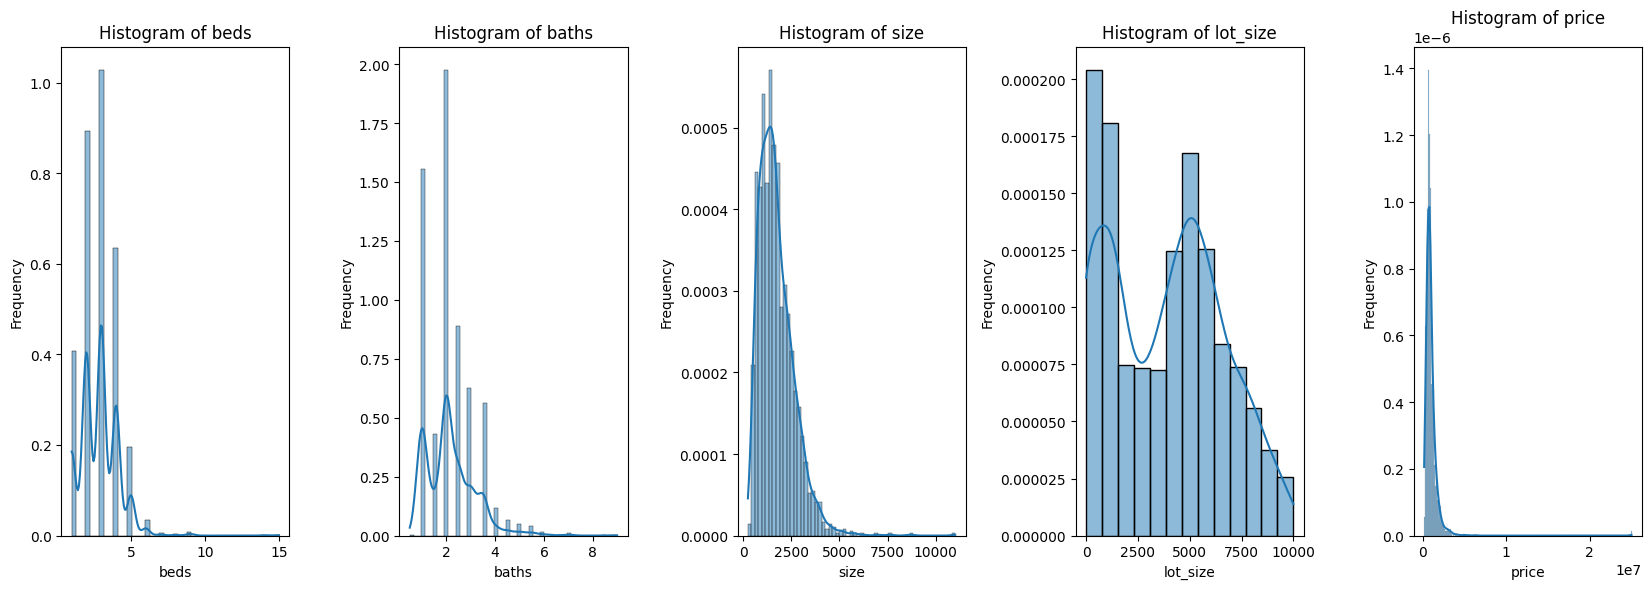

In [7]:
#Histograms
num_cols = len(df.columns)
num_rows = num_cols // 6 + (num_cols % 6 > 0) #calculating the needed amount of columns

fig, axes = plt.subplots(num_rows, 6, figsize=(20, 6* num_rows))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, ax=axes[i], stat='density')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(num_cols, num_rows * 6): #hiding any unused subplots
    fig.delaxes(axes[j]) 

plt.tight_layout()
plt.show()

It should be noted that there are some numerical columns that have discrete classes such as: 1,2,3,4,5. This means that these columns are techincally categorical. 

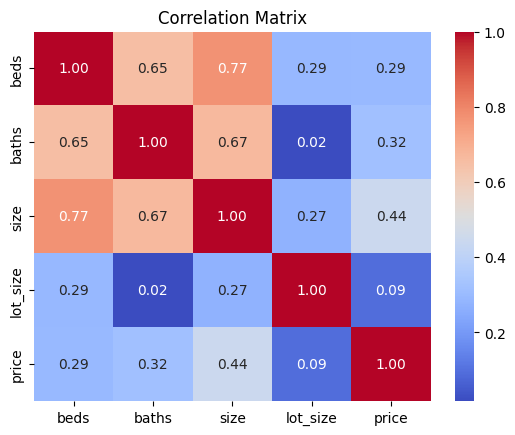

In [8]:
numeric_df = df.select_dtypes(include=[np.number])

# Correlation matrix
correlation_matrix = numeric_df.corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Looking at the correlation heat map, it can be noted that price (which is the important target feature for the dataset) is most highly correlated with size with 0.44. This means that out of all the other feature columns, size is the most crucial factor to take into account.

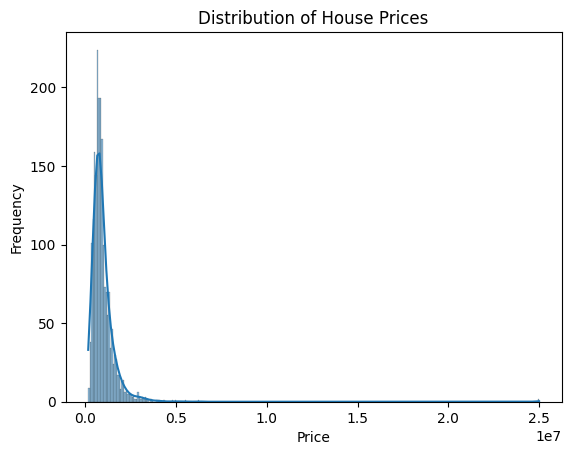

/home/emily4664/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


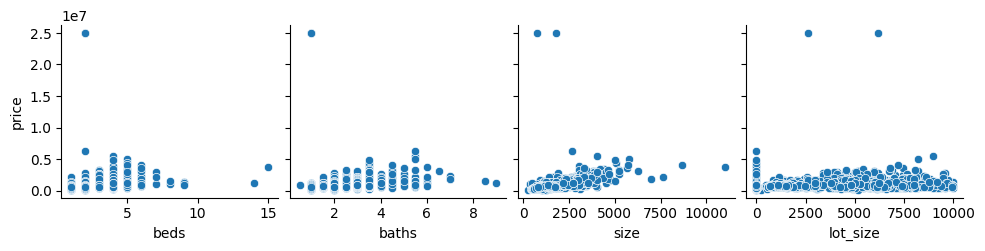

In [9]:
#histogram of price and price vs other variables
sns.histplot(df['price'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

sns.pairplot(df, y_vars='price', x_vars=df.columns.drop('price'))
plt.show()

After looking at the histogram, we can tell that the data is heavily right skewed. The heatmap and the scatter plot shows that the price column is just slightly correlated with some other features like size and beds.

# Data Preprocessing

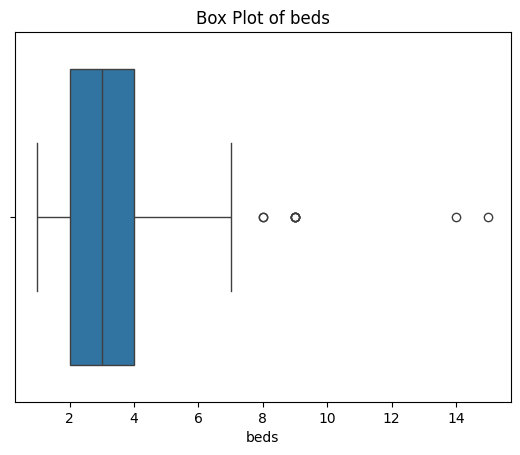

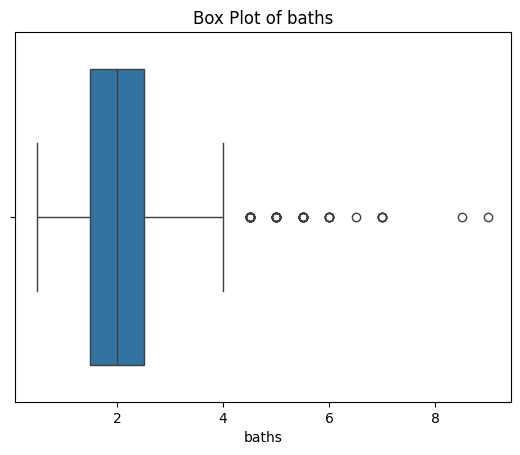

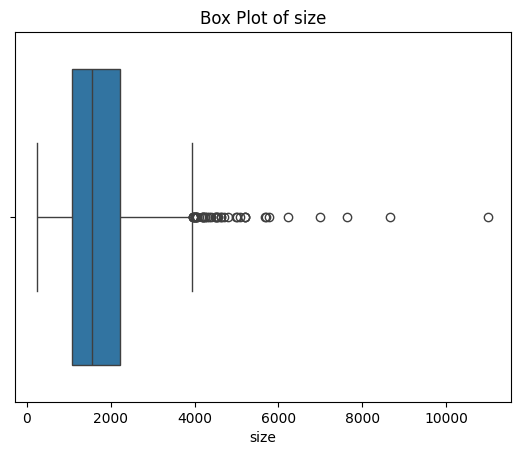

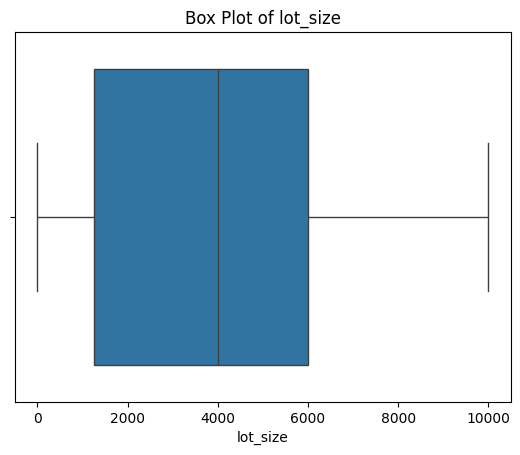

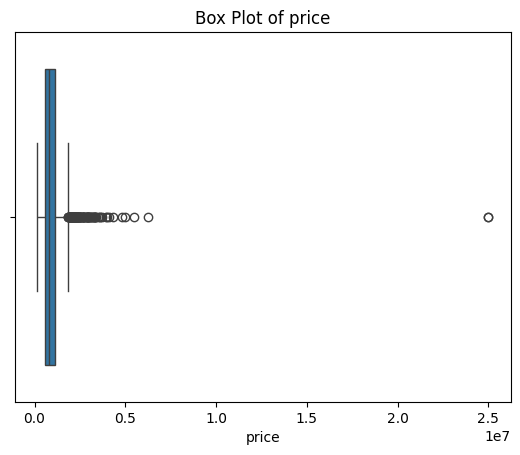

In [10]:
#looking at boxplot for outliers
for col in df.select_dtypes(include=['number']).columns:
  sns.boxplot(x=df[col])
  plt.title(f"Box Plot of {col}")
  plt.show()

After looking at the outliers, it would be good to introduce a cutoff, such using z-scores to take care of the outliers. Additionally, there are quite a bit of missing values in the lor_size column, which we can take care of with the KNN imputation technique.

**Cleaning**

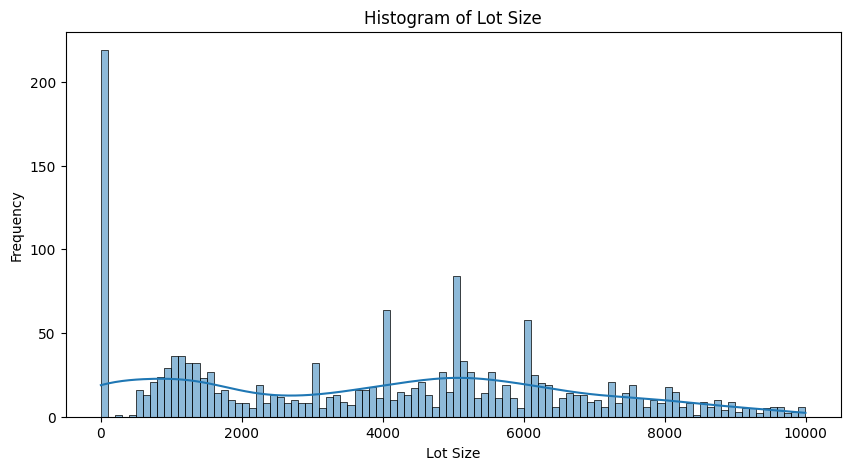

In [11]:
#Lot size column definitely has some problems with outliers.
#I'll focus on this one for now.

plt.figure(figsize=(10, 5))
sns.histplot(df['lot_size'], bins=100, kde=True)
plt.title('Histogram of Lot Size')
plt.xlabel('Lot Size')
plt.ylabel('Frequency')
plt.show()

In [12]:
#scale lot size 
df.loc[(df['lot_size'] >= 0) & (df['lot_size'] <= 10), 'lot_size'] *= 1000

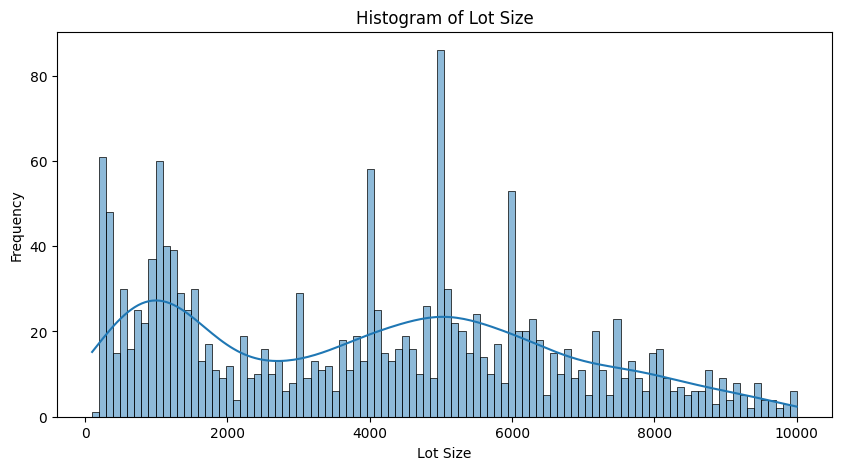

In [13]:
#look at lot size after scaling
plt.figure(figsize=(10, 5))
sns.histplot(df['lot_size'], bins=100, kde=True)
plt.title('Histogram of Lot Size')
plt.xlabel('Lot Size')
plt.ylabel('Frequency')
plt.show()

Previously lot size initially had a weirdly high number around 0, so in order to change the range (which was noted earlier went from 0.31 to 6000) everything was scaled up to the 1000s to match. The plot after sclaing looks much better. 

In [14]:
#outliers
z_scores = np.abs((df['price'] - df['price'].mean()) / df['price'].std())
outliers = df[z_scores > 3]

print("price outliers")
print(outliers)

price outliers
      beds  baths  size  lot_size     price
61       4    5.5  4040    8965.0   5495000
74       6    3.5  8660     280.0   4100000
557      4    3.5  3060     960.0   3931000
637      2    5.5  2659     520.0   6250000
805      5    5.5  5770    8226.0   5000000
964      5    3.5  5090     270.0   4325000
1359     2    1.0   730    6200.0  25000000
1700     2    1.0  1800    2613.0  25000000
1945     5    4.5  5704    7200.0   4000000
1998     4    3.5  4990     250.0   4815000


In [15]:
#trimming out extreme outliers
outliers_indices = z_scores[z_scores > 3].index
data = df.drop(outliers_indices)

If the z-score of an observation was higher or lower than 3 then it was classified as an extreme outlier and was cut from the dataset.

In [16]:
#KNN imputation
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(df)
data_imputed = knn_imputer.transform(data)
df = pd.DataFrame(data_imputed, columns=df.columns)

In [17]:
#checking missing values after imputation
missing_data=df.isnull().sum()
print("Missing data:\n", missing_data)

Missing data:
 beds        0
baths       0
size        0
lot_size    0
price       0
dtype: int64


Median imputation is known to change the distribution since the same number is going in to replace the empty values, so we decided to use KNN imputations instead to replace the missing values.

**Transformation**  
Since most of the data is very right skewed, the dataset should also be normalized, so that the skew won't affect the machine learning. In this case, because the right skew tial indicates a lot of high values, the normalization technique used should be something like a log transformation.

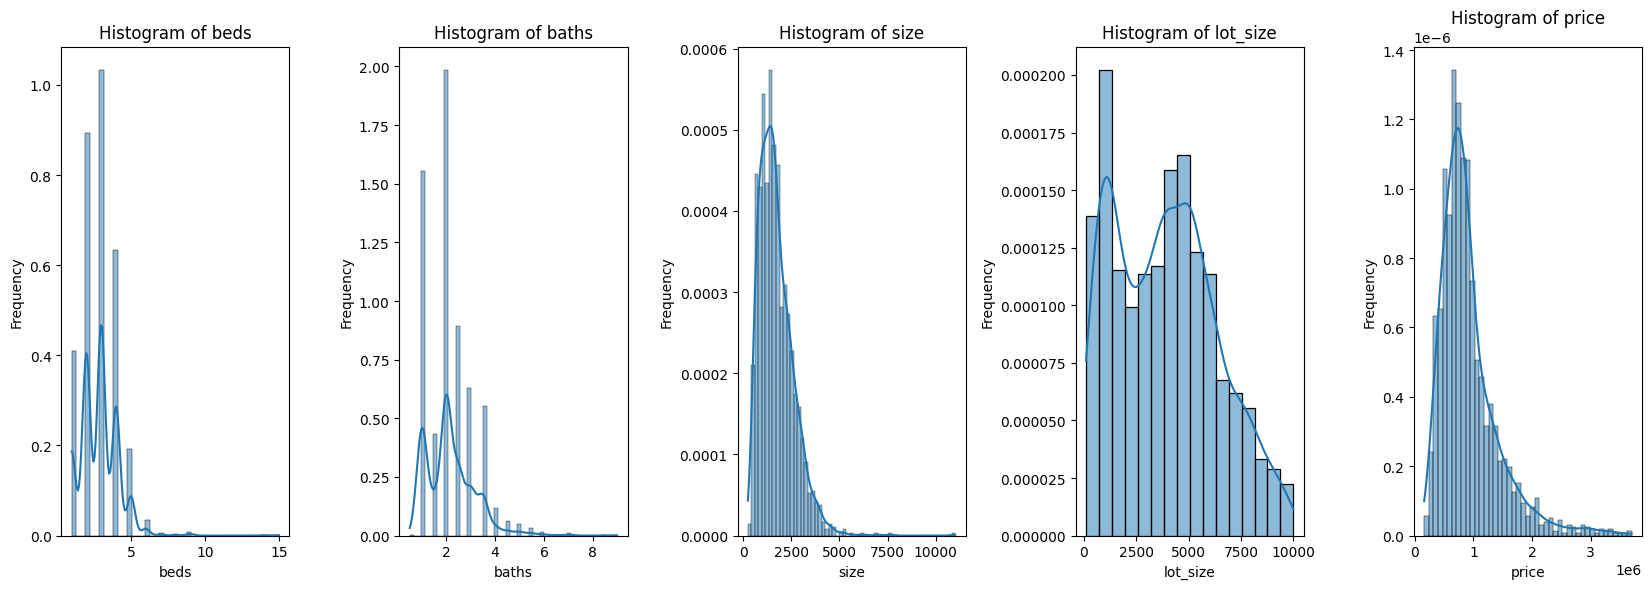

In [18]:
#Histograms
num_cols = len(df.columns)
num_rows = num_cols // 6 + (num_cols % 6 > 0) #calculating the needed amount of columns

fig, axes = plt.subplots(num_rows, 6, figsize=(20, 6* num_rows))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, ax=axes[i], stat='density')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(num_cols, num_rows * 6): #hiding any unused subplots
    fig.delaxes(axes[j]) 

plt.tight_layout()
plt.show()

In [19]:
#normalizing via log scale
from sklearn.preprocessing import RobustScaler

df_1 = np.log(df)
scaler = RobustScaler()
normalized_data = scaler.fit_transform(df_1)
print(normalized_data)

[[ 0.          0.43682921  0.69386368  0.35153794 -0.01034358]
 [ 0.4150375   0.          0.49715656 -2.03219683  0.22158786]
 [ 0.4150375   0.79374465  0.3704381  -0.01953876  0.28351775]
 ...
 [ 0.4150375   0.          0.43527823  0.38437989  0.59871978]
 [-0.5849625   0.         -0.90636955 -0.34395753 -0.50234484]
 [ 0.          0.          0.13135726  0.07731987 -0.31987583]]


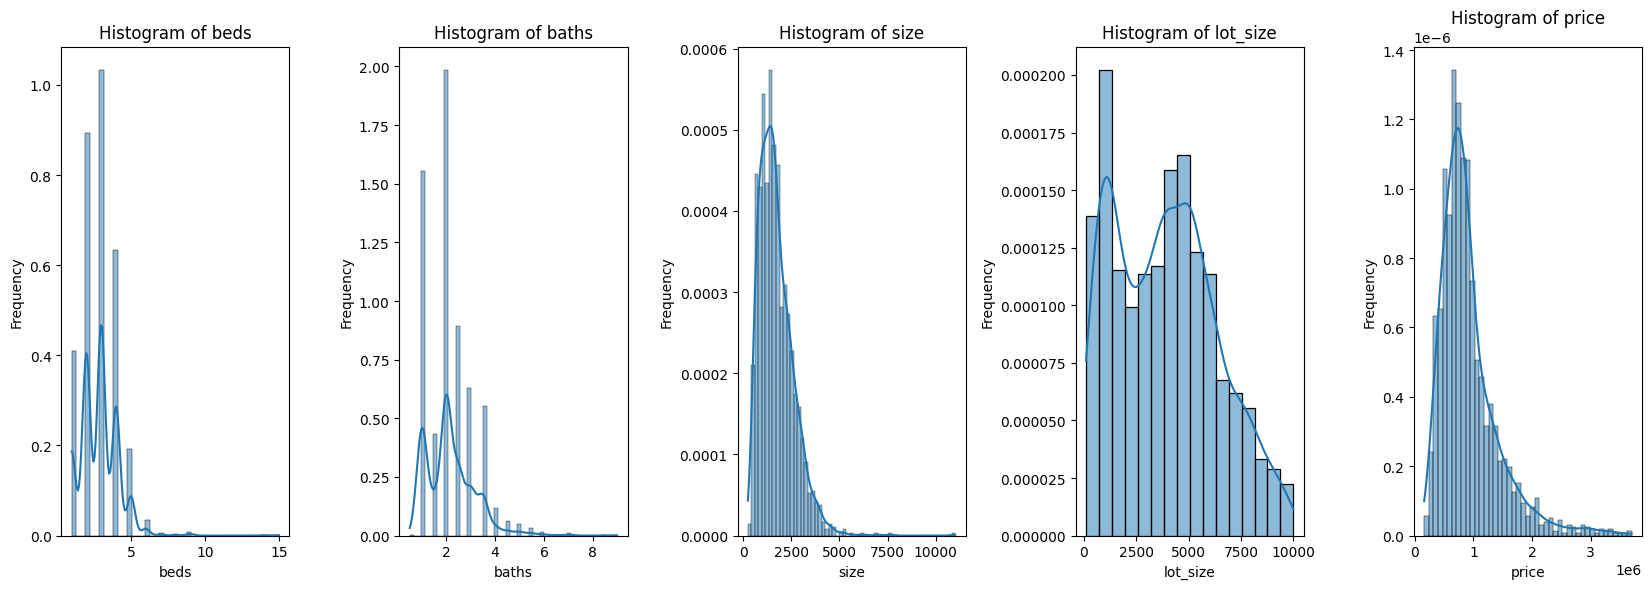

In [20]:
#Histograms
num_cols = len(df.columns)
num_rows = num_cols // 6 + (num_cols % 6 > 0) #calculating the needed amount of columns

fig, axes = plt.subplots(num_rows, 6, figsize=(20, 6* num_rows))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, ax=axes[i], stat='density')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(num_cols, num_rows * 6): #hiding any unused subplots
    fig.delaxes(axes[j]) 

plt.tight_layout()
plt.show()

It seems that the log transofrmation and robust scaler did not affect the distribution shape of the data very much.

**Feature Engineering**  
Additionally, there are only 5 feature columns, so we should probably do some feature engineering in order to create more columns for the machine learning algorithm.

In [21]:
df['price_per_sqft']=df['price']/df['size']

In [22]:
df['total_rooms']=df['beds']+df['baths']

In [23]:
df['lot_size_per_sqft'] = df['lot_size'] / df['size']

In [24]:
df.head()

,beds,baths,size,lot_size,price,price_per_sqft,total_rooms,lot_size_per_sqft
0,3.0,2.5,2590.0,6000.0,795000.0,306.949807,5.5,2.316602
1,4.0,2.0,2240.0,310.0,915000.0,408.482143,6.0,0.138393
2,4.0,3.0,2040.0,3783.0,950000.0,465.686275,7.0,1.854412
3,4.0,3.0,3800.0,5175.0,1950000.0,513.157895,7.0,1.361842
4,2.0,2.0,1042.0,3260.4,950000.0,911.708253,4.0,3.128983


# Model Development and Evaluation

**Model 1. Multiple Linear Regression**

In [25]:
import pandas as pd #Loads the pandas library for data manipulation.
from sklearn.model_selection import train_test_split #Provides a function to split data into training and testing sets.
from sklearn.preprocessing import OneHotEncoder # Offers a tool to convert categorical variables into a numerical format.
from sklearn.compose import ColumnTransformer #Enables transformations on DataFrame columns.
from sklearn.pipeline import Pipeline # Allows sequential application of a list of transformations and a final estimator.
from sklearn.linear_model import LinearRegression #Loads a linear regression model for predictive analysis.
from sklearn.metrics import mean_squared_error, r2_score # Imports functions to compute model metrics.
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import numpy as np #Imports the NumPy library for numerical computations.
import matplotlib.pyplot as plt # Loads the matplotlib library for plotting graphs.

In [26]:
X = df.drop('price', axis=1) 
y = df['price']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
transformer = ColumnTransformer(transformers=[
    ('num', StandardScaler(), X.columns)  # Scale all numerical columns
])

regression_pipeline = Pipeline(steps=[('transformer', transformer), ('regressor', LinearRegression())])
regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['beds', 'baths', 'size', 'lot_size', 'price_per_sqft', 'total_rooms',
       'lot_size_per_sqft'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [29]:
y_pred = regression_pipeline.predict(X_test)

In [30]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print("RMSE: ", rmse)
print("R²: ", r2)

RMSE:  178979.51510522809
R²:  0.8473176522763024


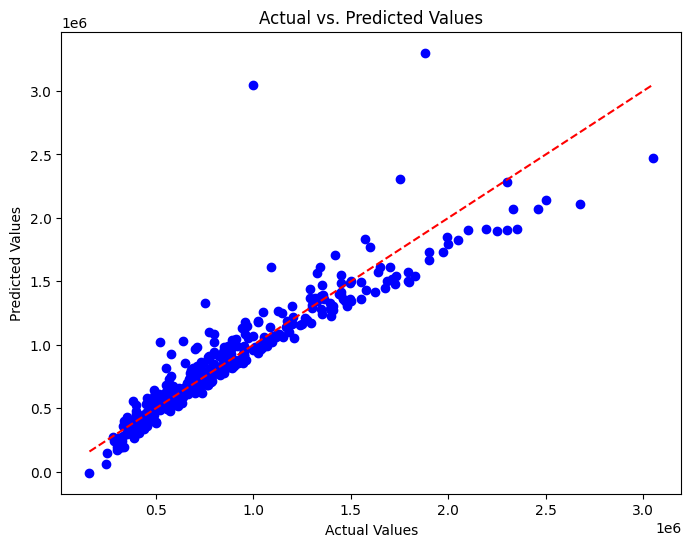

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

The chart above shows that the model is generally quite good at predicting values that are on the lower side but underpredicts prices that should be higher. The R2 of the model is 0.847 which is quite good as it means that the model can hande a good amount of variability from the data. The rmse score is 178979.5 which is lower than the standard deviation of the price column at 944095.4, which means that the rmse score is quite good as well. 

**Model 2: XGboost**

In [33]:
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
#First using XGBoost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

xg_reg.fit(X_train, y_train)

y_pred = xg_reg.predict(X_test)

print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred)) #Getting two very different results. Outliers may be why.

Mean Absolute Percentage Error (MAPE): 0.02598983519270564
Mean Squared Error (MSE): 1240297907.83012


The MAPE is close to zero at 0.02599 which indicates a pretty good fit with the model. However, the MSE is quite high at 0.02598983519270564 due to outliers affecting the data. 

In [34]:
actual_values=df['price']
predicted_values=y_pred

In [35]:
#make sure predicted and actual values are the same length
min_len = min(len(predicted_values), len(actual_values))
predicted_values = predicted_values[:min_len]
actual_values = actual_values[:min_len]

In [36]:
mse_errors = (predicted_values - actual_values) ** 2
mape_errors = np.abs((actual_values - predicted_values) / actual_values) 

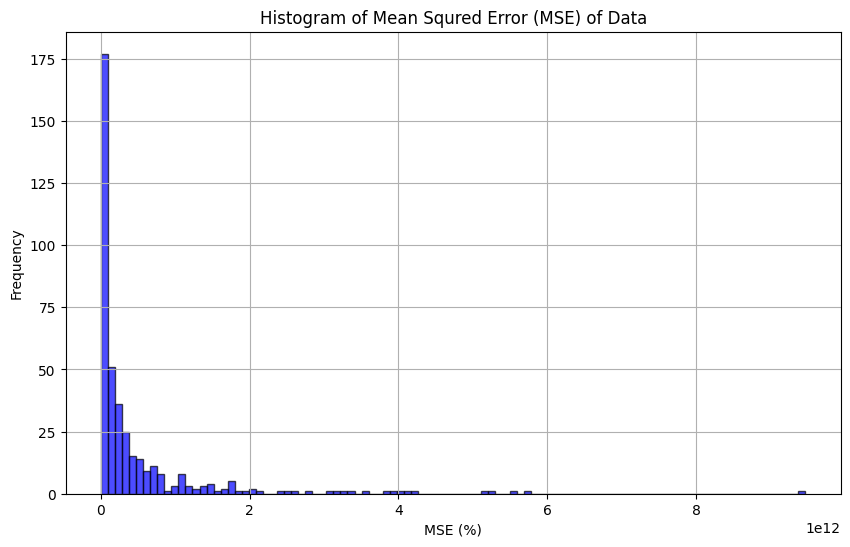

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(mse_errors, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Mean Squred Error (MSE) of Data')
plt.xlabel('MSE (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

It should be noted that the x-axis is to the power of 12. The overall mse is not very good as the MSE from the model was 1240297907.83012. However, the plot of the MSE of each observation shows that the mse distribution is skewed due to the influence of the outliers and other noise. Otherwise, the other mse grouping near 0 shows that the error is not too bad as it is mostly near the score given from the model.

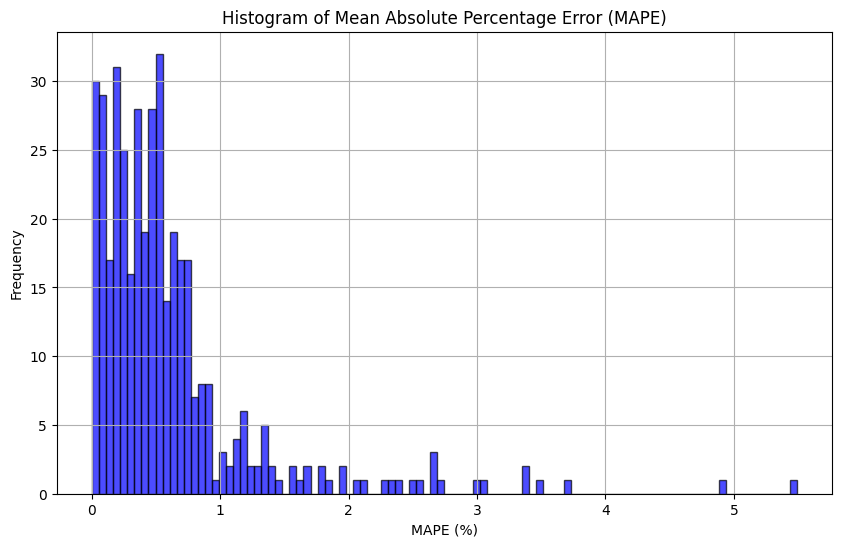

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(mape_errors, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Mean Absolute Percentage Error (MAPE)')
plt.xlabel('MAPE (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The overall mape scores are pretty good considering that the xgboost gave a score of 0.02598983519270564. The plot for mape is also a little bit skewed with values reaching out into 5-6 range. However, the bulk of the mape scores for each observation is in the 0-1 range which shows that the absolute error rates for most of the data is quite good as they are less than 1%.